Game of Thrones to word vectors
---

[![](https://i.ytimg.com/vi/pY9EwZ02sXU/hqdefault.jpg)](https://youtu.be/pY9EwZ02sXU?list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3)

In [14]:
# import dependencies

from __future__ import absolute_import, division, print_function

# for word encoding
import codecs

#regex
import glob
import re

#concurrency
import multiprocessing

# os libs
import os
import pprint

#natural language toolkit
import nltk
# word vectors
import gensim.models.word2vec as w2v

import sklearn.manifold

# math
import numpy as np
import pandas as pd

# analytics and visualization
import matplotlib as plt
import seaborn as sns

unable to import 'smart_open.gcs', disabling that module
/home/dillon/projects/line-art-gan/env/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [15]:
# Step 1: process data
# clean words
nltk.download('punkt') # pretrained tokenizer
nltk.download('stopwords') # useless filler words (and, the, an, a)

[nltk_data] Downloading package punkt to /home/dillon/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/dillon/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# get book names, matching text files
book_files = sorted(glob.glob("data/*.txt"))
book_files

['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

In [18]:
# combine books into one corpus
corpus_raw = u''
for book_file in book_files:
    print('reading {}'.format(book_file))
    with codecs.open(book_file, 'r', 'utf-8') as book_reader:
        corpus_raw += book_reader.read()
    print('corpus raw is now {} chars long\n'.format(len(corpus_raw)))

reading data/got1.txt
corpus raw is now 1770659 chars long

reading data/got2.txt
corpus raw is now 4071041 chars long

reading data/got3.txt
corpus raw is now 6391405 chars long

reading data/got4.txt
corpus raw is now 8107945 chars long

reading data/got5.txt
corpus raw is now 9719485 chars long



In [19]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [23]:
def sentence_to_wordslist(raw):
    clean = re.sub(r'[^a-zA-Z]', ' ', raw)
    words = clean.split()
    return words

In [25]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordslist(raw_sentence))
        
print(raw_sentences[5])
print(sentence_to_wordslist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [26]:
token_count = sum([len(sentence) for sentence in sentences])
print('the book corpus contains {} tokens'.format(token_count))

the book corpus contains 1818103 tokens


Train Word 2 Vev
---

In [34]:
# 3 main tasks that vectors help with:
# -----------------------------------
# 1. distance
# 2. similarity
# 3. ranking

# dimensionality of the the resulting word vectors
# more demensions => expensive to train but more accurate 
num_features = 300

# min word count threshold
min_word_count = 3

# num threads faster training
num_workers = multiprocessing.cpu_count()

# context window length
context_size = 7

# downsample setting freq words (frequent words are not used as often for model)
downsampling = 1e-3

# epochs
epochs = 10

# rng seed
seed = 1

## word vectors

---

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F1400%2F1*jpnKO5X0Ii8PVdQYFO2z1Q.png&f=1&nofb=1)

In [29]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

thrones2vec.build_vocab(sentences)
print('word2vec vocab length {}'.format(len(thrones2vec.wv.vocab)))

word2vec vocab length 17277


In [35]:
thrones2vec.train(
    sentences, 
    total_examples=thrones2vec.corpus_count, 
    epochs=epochs
)

(14045269, 18181030)

In [39]:
os.makedirs('trained', exist_ok=True)

#save model
thrones2vec.save('trained/thrones.w2v')

#load model
thrones = w2v.Word2Vec.load('trained/thrones.w2v')

In [54]:
# T Stotasitc distributed neighbor embeded (for visualiation)
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vec_matrix = thrones.wv.vectors

In [56]:
# training model ... please wait for completion
all_word_vec_matrix_2d = tsne.fit_transform(all_word_vec_matrix)

In [58]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vec_matrix_2d[thrones.wv.vocab[word].index])
            for word in thrones.wv.vocab
        ]
    ],
    columns=['word', 'x', 'y']
)

In [59]:
points.head(10)

,word,x,y
0,This,-24.040268,-19.671926
1,edition,-29.955923,47.319603
2,the,4.688735,10.987281
3,complete,-6.163726,7.658126
4,of,5.833957,7.779453
5,original,-6.926312,0.817522
6,hardcover,-29.279768,46.940643
7,ONE,-38.799992,37.548141
8,A,-1.538196,-4.768435
9,OF,-37.066803,46.872189


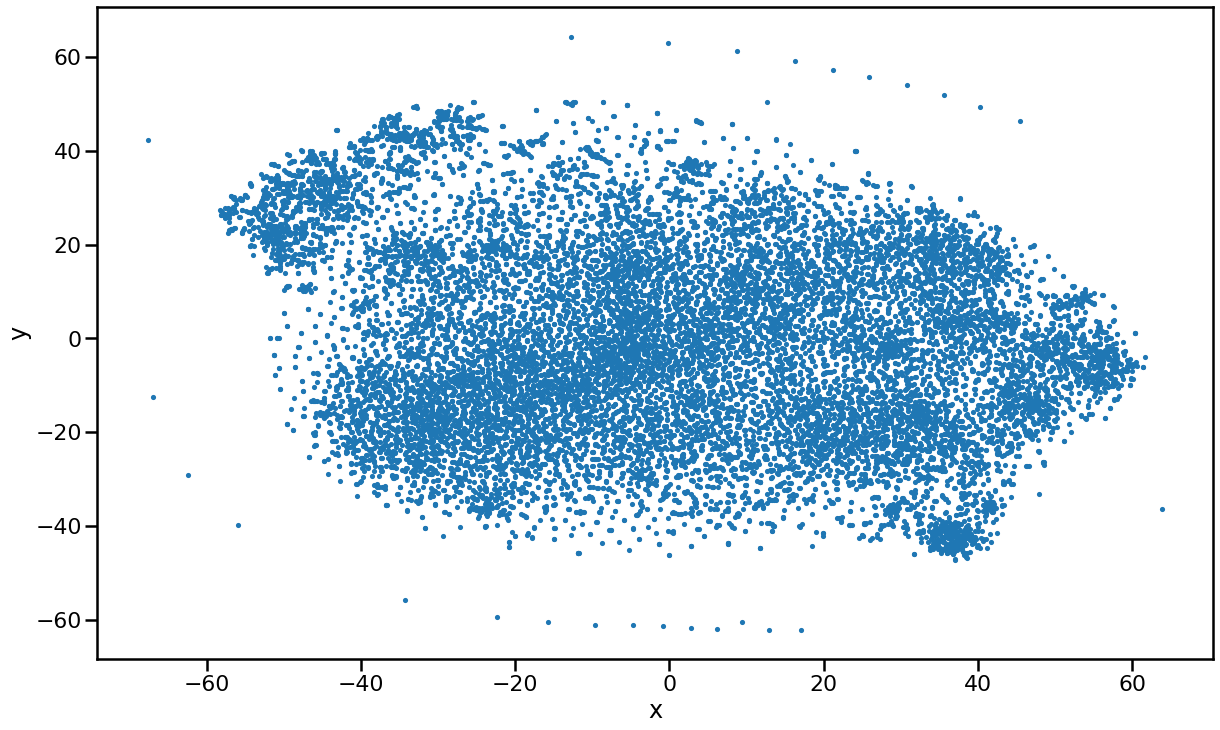

In [61]:
sns.set_context('poster')
points.plot.scatter('x', 'y', s=10, figsize=(20,12))

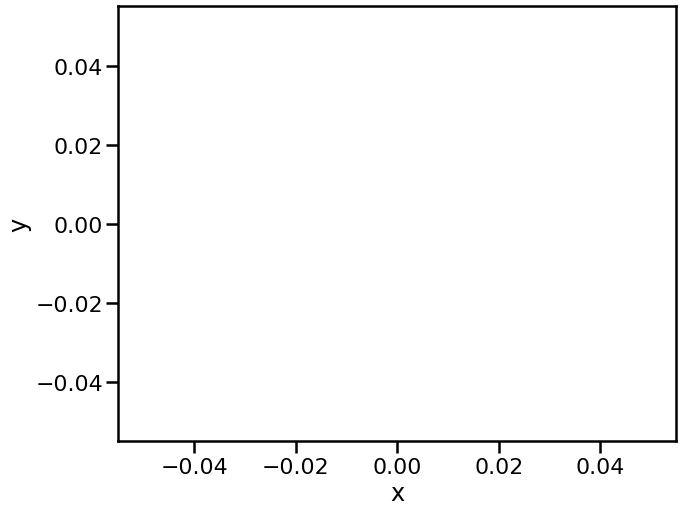

In [62]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
        
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

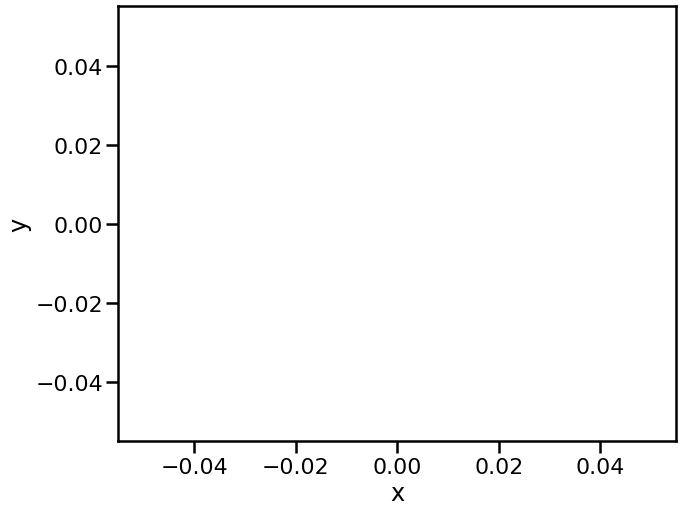

In [63]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

In [65]:
thrones.wv.most_similar("Stark")

[('Eddard', 0.6632357835769653),
 ('executed', 0.5423938632011414),
 ('divulge', 0.5155653953552246),
 ('Lyanna', 0.5061956644058228),
 ('boyhood', 0.5053333044052124),
 ('Burner', 0.4934510588645935),
 ('Underfoot', 0.4913959503173828),
 ('Winterfell', 0.48702216148376465),
 ('plotted', 0.4858506917953491),
 ('beheaded', 0.48316675424575806)]

In [66]:
thrones.wv.most_similar("Aerys")

[('Jaehaerys', 0.6689732074737549),
 ('II', 0.6494914293289185),
 ('Conciliator', 0.6119110584259033),
 ('Mad', 0.600814700126648),
 ('Unlikely', 0.5909935235977173),
 ('Maekar', 0.5834484100341797),
 ('Daeron', 0.5833534002304077),
 ('V', 0.5779843330383301),
 ('Unworthy', 0.5739723443984985),
 ('Defiance', 0.5725141763687134)]

In [67]:
thrones.wv.most_similar("direwolf")

[('wolf', 0.5919507145881653),
 ('SHAGGYDOG', 0.5648506879806519),
 ('pup', 0.546251118183136),
 ('Ghost', 0.5457414388656616),
 ('GHOST', 0.5223908424377441),
 ('OSHA', 0.49516335129737854),
 ('muzzle', 0.49417755007743835),
 ('Rickon', 0.49230095744132996),
 ('direwolves', 0.4891664981842041),
 ('albino', 0.4788872003555298)]

In [70]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as hippocras is related to wine
Arya is related to Nymeria, as histories is related to dragons


'histories'